##Dataset from teammate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
# from kagglehub import KaggleDatasetAdapter # Not needed for dataset_download

# Set the handle for the dataset
dataset_handle = "kronomy/helmet-dataset-by-osf-lite"

# Download the latest version of the dataset
# This will download the entire dataset to a local path
try:
  path = kagglehub.dataset_download(dataset_handle)
  print(f"Dataset downloaded to: {path}")
except Exception as e:
  print(f"Error downloading dataset: {e}")
  path = None # Set path to None if download fails for subsequent checks


Dataset downloaded to: /kaggle/input/helmet-dataset-by-osf-lite


In [ ]:
# Path to dataset
# dataset_path = '/content/drive/My Drive/dataset/' # Original line
dataset_path = path + '/helmet-dataset' # Use the path from kagglehub.dataset_download

print(f"Dataset path set to: {dataset_path}")

Dataset path set to: /kaggle/input/helmet-dataset-by-osf-lite/helmet-dataset


In [ ]:
!git clone https://github.com/facebookresearch/detr.git   #cloning github repo of detr to import its unique loss

fatal: destination path 'detr' already exists and is not an empty directory.


In [ ]:
import sys
sys.path.append('/content/detr')  # repo root, so "util" is visible


In [ ]:
from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion

In [ ]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn # Add this line to import the nn module
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS########################
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features

        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries

    def forward(self,images):
        return self.model(images)

In [ ]:
n_folds = 5
seed = 42
num_classes = 2
num_queries = 100
null_class_coef = 0.5
BATCH_SIZE = 4
LR = 2e-5
EPOCHS = 5

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:

seed_everything(seed)

In [ ]:
!pip install albumentations

In [ ]:
# ==========================
# Imports
# ==========================
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import albumentations as A
from tqdm.autonotebook import tqdm

# ==========================
# Global Settings
# ==========================
BATCH_SIZE = 8
EPOCHS = 10
num_queries = 100
dataset_path = '/content/drive/My Drive/dataset'  # adjust if needed

# Label map (consistent across whole pipeline)
detr_label_map = {
    'DHelmet': 0,
    'DNoHelmet': 1,
    'DHelmetP1Helmet': 2,
    'DNoHelmetP1NoHelmet': 3
}

# ==========================
# DataFrame Loading + Path Correction
# ==========================
detr_save_dir = os.path.join(dataset_path, 'preprocessed_data', 'detr_dataframes')

df_train_detr = pd.read_csv(os.path.join(detr_save_dir, 'df_train_detr.csv'))
df_val_detr   = pd.read_csv(os.path.join(detr_save_dir, 'df_val_detr.csv'))

# Fix image paths by replacing old base with current dataset path
old_base = '/content/drive/My Drive/dataset'
df_train_detr['image_path'] = df_train_detr['image_path'].str.replace(old_base, dataset_path)
df_val_detr['image_path']   = df_val_detr['image_path'].str.replace(old_base, dataset_path)

# ==========================
# Albumentations Transforms
# ==========================
def get_train_transforms():
    try:
        from albumentations import Cutout
        cutout_transform = Cutout(num_holes=8, max_h_size=64, max_w_size=64,
                                  fill_value=0, p=0.5)
    except ImportError:
        cutout_transform = None

    transforms_list = [
        A.OneOf([
            A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.9),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)
        ], p=0.9),
        A.ToGray(p=0.01),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Resize(height=512, width=512, p=1),
    ]
    if cutout_transform is not None:
        transforms_list.append(cutout_transform)

    return A.Compose(
        transforms_list,
        p=1.0,
        bbox_params=A.BboxParams(format='coco', min_area=0, min_visibility=0, label_fields=['labels'])
    )

def get_valid_transforms():
    return A.Compose([
        A.Resize(height=512, width=512, p=1.0)
    ],
    p=1.0,
    bbox_params=A.BboxParams(format='coco', min_area=0, min_visibility=0, label_fields=['labels'])
    )

# ==========================
# Dataset Class
# ==========================
class DETRDataset(Dataset):
    def __init__(self, dataframe, img_size=(512, 512), transforms=None):
        self.dataframe = dataframe
        self.image_paths = self.dataframe['image_path'].unique().tolist()
        self.img_size = img_size
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        orig_w, orig_h = img.size
        img = np.array(img).astype(np.uint8)

        # Get annotations
        records = self.dataframe[self.dataframe['image_path'] == img_path].copy()

        # --- Modified section to handle single-row annotations and empty lists ---
        boxes_xywh_list = []
        labels_list = []

        if not records.empty:
            # Check if the annotation columns contain lists or single values
            # Assuming if one column has a list, all annotation columns have lists
            # Or if one has a single value, all have single values for that row
            is_list_data = isinstance(records['x'].iloc[0], list)

            for index, row in records.iterrows():
                if is_list_data:
                    # Data is already in lists (e.g., from previous processing steps)
                    if len(row['x']) > 0: # Check if the lists are not empty
                        num_boxes_in_row = len(row['x'])
                        for i in range(num_boxes_in_row):
                            boxes_xywh_list.append([row['x'][i], row['y'][i], row['w'][i], row['h'][i]])
                            labels_list.append(row['class_id'][i])
                else:
                     # Data is in single values per row (typical for raw CSV)
                     # Check if bounding box values are not zero/invalid
                     if row['w'] > 0 and row['h'] > 0:
                         boxes_xywh_list.append([row['x'], row['y'], row['w'], row['h']])
                         labels_list.append(row['class_id'])


        boxes_xywh = np.array(boxes_xywh_list, dtype=np.float32) if boxes_xywh_list else np.zeros((0, 4), dtype=np.float32)
        labels = np.array(labels_list, dtype=np.int64) if labels_list else np.zeros((0,), dtype=np.int64)
        # --- End of Modified section ---


        # Filter invalid bboxes BEFORE transforms (if any exist after initial processing)
        if len(boxes_xywh) > 0:
            valid_mask = (boxes_xywh[:, 2] > 0) & (boxes_xywh[:, 3] > 0)
            if not valid_mask.all():
                # print(f"Dropped {np.sum(~valid_mask)} invalid bbox(es) in {img_path}") # Optional warning
                boxes_xywh = boxes_xywh[valid_mask]
                labels = labels[valid_mask]


        if self.transforms:
            sample = {
                'image': img,
                'bboxes': boxes_xywh.tolist(), # Convert numpy array to list for Albumentations
                'labels': labels.tolist()   # Convert numpy array to list for Albumentations
            }
            sample = self.transforms(**sample)
            img = sample['image']
            boxes_xywh = np.array(sample['bboxes']).astype(np.float32) # Convert back to numpy array
            labels = np.array(sample['labels']).astype(np.int64)     # Convert back to numpy array


        # Get new image size after transforms
        if isinstance(img, np.ndarray):
            h_after, w_after, _ = img.shape
        else:
            _, h_after, w_after = img.shape  # Tensor [C,H,W]

        # Convert xywh → normalized cxcywh
        boxes_cxcywh = np.zeros_like(boxes_xywh, dtype=np.float32)
        if len(boxes_xywh) > 0:
            # Ensure division by non-zero dimensions
            w_after_safe = max(w_after, 1e-6)
            h_after_safe = max(h_after, 1e-6)
            boxes_cxcywh[:, 0] = (boxes_xywh[:, 0] + boxes_xywh[:, 2] / 2) / w_after_safe
            boxes_cxcywh[:, 1] = (boxes_xywh[:, 1] + boxes_xywh[:, 3] / 2) / h_after_safe
            boxes_cxcywh[:, 2] = boxes_xywh[:, 2] / w_after_safe
            boxes_cxcywh[:, 3] = boxes_xywh[:, 3] / h_after_safe

             # Clamp normalized coordinates to [0, 1] to handle potential floating point errors or edge cases
            boxes_cxcywh = np.clip(boxes_cxcywh, 0.0, 1.0)


        # Compute area
        area = boxes_xywh[:, 2] * boxes_xywh[:, 3] if len(boxes_xywh) > 0 else np.zeros((0,), dtype=np.float32)


        target = {
            'boxes': torch.as_tensor(boxes_cxcywh, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.long),
            'image_id': torch.tensor([idx]),
            'area': torch.as_tensor(area, dtype=torch.float32),
            'orig_size': torch.as_tensor([orig_h, orig_w], dtype=torch.int64),
            'size': torch.as_tensor([h_after, w_after], dtype=torch.int64),
        }

        return img, target


# ==========================
# Collate Function
# ==========================
def collate_fn_detr(batch):
    images = [item[0] for item in batch]  # [H,W,C]
    targets = [item[1] for item in batch]

    images = [torch.from_numpy(img).permute(2, 0, 1).float() for img in images]
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    images = [normalize(img) for img in images]
    images = torch.stack(images, 0)

    return images, targets

# ==========================
# DataLoaders
# ==========================
train_dataset_detr = DETRDataset(df_train_detr, transforms=get_train_transforms())
val_dataset_detr   = DETRDataset(df_val_detr, transforms=get_valid_transforms())

train_loader = DataLoader(train_dataset_detr, batch_size=BATCH_SIZE,
                          shuffle=True, num_workers=2, collate_fn=collate_fn_detr)
val_loader   = DataLoader(val_dataset_detr, batch_size=BATCH_SIZE,
                          shuffle=False, num_workers=2, collate_fn=collate_fn_detr)

print("DETR DataLoaders created.")
print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)}")

# ==========================
# DETR Model
# ==========================
class DETRModel(nn.Module):
    def __init__(self, num_classes, num_queries):
        super(DETRModel, self).__init__()
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        in_features = self.model.class_embed.in_features
        self.model.class_embed = nn.Linear(in_features, num_classes)
        self.model.num_queries = num_queries

    def forward(self, images):
        return self.model(images)

DETR DataLoaders created.
Train batches: 123 | Val batches: 17


In [ ]:
# Create DETR Datasets
train_dataset_detr = DETRDataset(
    dataframe=df_train_detr,
    transforms=get_train_transforms(),
    img_size=(512, 512)
)

val_dataset_detr = DETRDataset(
    dataframe=df_val_detr,
    transforms=get_valid_transforms(),
    img_size=(512, 512)
)

# Create DataLoaders
train_data_loader_detr = DataLoader(
    train_dataset_detr,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn_detr
)

valid_data_loader_detr = DataLoader(
    val_dataset_detr,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn_detr
)


In [ ]:
# ==========================
# Training Utilities
# ==========================
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# ==========================
# Run DETR Training
# ==========================
def run_detr_training(train_data_loader, valid_data_loader, matcher, weight_dict, losses, num_queries, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # --- Model + Criterion ---
    # num_classes for the model should include the "no object" class
    num_classes_model = len(detr_label_map) + 1
    print(f"Number of classes for model (including no object): {num_classes_model}")
    print(f"Number of queries: {num_queries}")
    model = DETRModel(num_classes=num_classes_model, num_queries=num_queries)
    print("DETRModel created.")

    # num_classes for the criterion should be the number of object classes
    num_classes_criterion = len(detr_label_map)
    print(f"Number of classes for criterion (object classes only): {num_classes_criterion}")
    criterion = SetCriterion(
        num_classes_criterion, matcher, weight_dict,
        eos_coef=0.1, losses=losses
    )
    print("SetCriterion created.")

    print("Moving model to device...")
    model.to(device)
    print("Model moved to device.")

    print("Moving criterion to device...")
    criterion.to(device)
    print("Criterion moved to device.")


    # --- Optimizer with different LRs ---
    param_dicts = [
        {"params": [p for n, p in model.named_parameters()
                    if "backbone" not in n and p.requires_grad], "lr": 1e-4},
        {"params": [p for n, p in model.named_parameters()
                    if "backbone" in n and p.requires_grad], "lr": 1e-5},
    ]
    optimizer = torch.optim.AdamW(param_dicts, lr=1e-4, weight_decay=1e-4)

    # --- LR scheduler ---
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=40, gamma=0.1
    )

    # --- Training loop ---
    best_loss = float("inf")
    for epoch in range(epochs):  # uses the epochs argument passed to the function
        print(f"\nEpoch {epoch+1}/{epochs}")

        # --- Training function ---
        def train_fn(loader, model, criterion, optimizer, device, scheduler=None):
            model.train()
            criterion.train()
            summary_loss = AverageMeter()

            for images, targets in tqdm(loader):
                images = images.to(device)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                outputs = model(images)
                loss_dict = criterion(outputs, targets)
                losses = sum(loss_dict[k] * criterion.weight_dict[k]
                             for k in loss_dict.keys() if k in criterion.weight_dict)

                optimizer.zero_grad()
                losses.backward()
                optimizer.step()
                if scheduler is not None:
                    scheduler.step()

                summary_loss.update(losses.item(), images.size(0))

            return summary_loss

        # --- Evaluation function ---
        def eval_fn(loader, model, criterion, device):
            model.eval()
            criterion.eval()
            summary_loss = AverageMeter()

            with torch.no_grad():
                for images, targets in tqdm(loader):
                    images = images.to(device)
                    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                    outputs = model(images)
                    loss_dict = criterion(outputs, targets)
                    losses = sum(loss_dict[k] * criterion.weight_dict[k]
                                 for k in loss_dict.keys() if k in criterion.weight_dict)

                    summary_loss.update(losses.item(), images.size(0))

            return summary_loss

        train_loss = train_fn(train_data_loader, model, criterion, optimizer, device, lr_scheduler)
        valid_loss = eval_fn(valid_data_loader, model, criterion, device)

        print(f"|EPOCH {epoch+1}| TRAIN_LOSS {train_loss.avg:.4f} | VALID_LOSS {valid_loss.avg:.4f}|")

        # Save best model
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            model_save_dir = os.path.join('/content/drive/My Drive/Assignment/DETR')
            os.makedirs(model_save_dir, exist_ok=True)
            model_save_path = os.path.join(model_save_dir, 'detr_best.pth')
            torch.save(model.state_dict(), model_save_path)
            print(f" Best model saved at epoch {epoch+1} with val_loss={best_loss:.4f}")

    return model

In [ ]:
# Ensure matcher, weight_dict, and losses are defined before calling run_detr_training
# These should be defined in a previous cell, e.g., cell nLHfXXiMXJn0
# from detr.models.matcher import HungarianMatcher
# from detr.models.detr import SetCriterion
# matcher = HungarianMatcher()
# weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}
# losses = ['labels', 'boxes', 'cardinality']

# Ensure train_data_loader_detr and valid_data_loader_detr are defined
# These should be defined in a previous cell, e.g., cell VK8CEKL16-9X or ec4b2079/8ecbbf9d

# Call the run_detr_training function with the correct arguments
trained_model = run_detr_training(
    train_data_loader_detr,
    valid_data_loader_detr,
    matcher=matcher, # Pass matcher
    weight_dict=weight_dict, # Pass weight_dict
    losses=losses, # Pass losses
    num_queries=num_queries, # Pass num_queries
    epochs=5 # Use the global EPOCHS variable
)

Using device: cuda
Number of classes for model (including no object): 5
Number of queries: 100


Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DETRModel created.
Number of classes for criterion (object classes only): 4
SetCriterion created.
Moving model to device...
Model moved to device.
Moving criterion to device...
Criterion moved to device.

Epoch 1/5


  0%|          | 0/123 [00:00<?, ?it/s]

Process Process-2:
Traceback (most recent call last):
  File "/usr/lib/python3.12/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.12/multiprocessing/util.py", line 363, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.12/multiprocessing/util.py", line 303, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.12/multiprocessing/util.py", line 227, in __call__
    res = self._callback(*self._args, **self._kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/util.py", line 136, in _remove_temp_dir
    rmtree(tempdir, onerror=onerror)
  File "/usr/lib/python3.12/shutil.py", line 731, in rmtree
    sys.audit("shutil.rmtree", path, dir_fd)
KeyboardInterrupt
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7b64b51d5ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tqdm/notebook.py", line 255, in __iter__
  

KeyboardInterrupt: 

##Evaluation


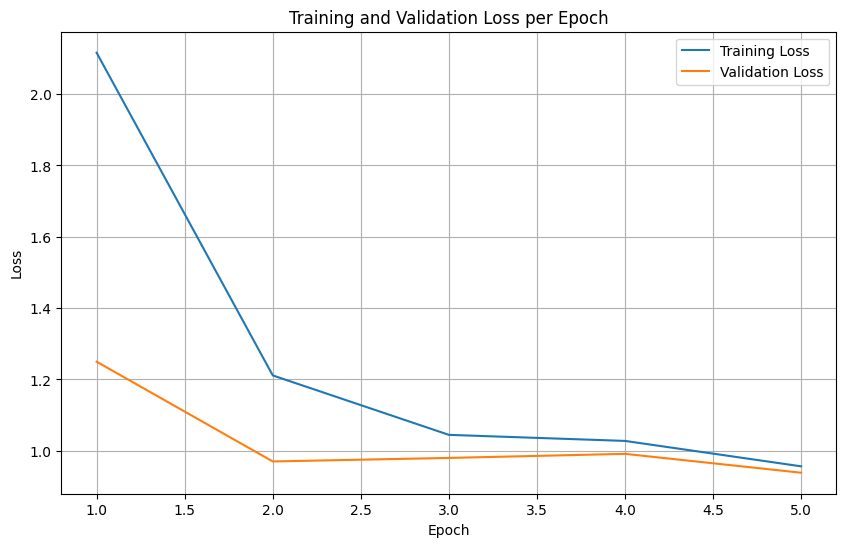

In [ ]:
# The loss values were printed in the output of the training cell (01bfe3c9).
# We need to manually extract these values for plotting.

train_losses = [2.1163, 1.2112, 1.0445, 1.0275, 0.9562]
valid_losses = [1.2497, 0.9699, 0.9798, 0.9912, 0.9383]
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

## Implement map calculation

### Subtask:
Add code to calculate Mean Average Precision (mAP) on the validation set. This will likely involve computing IoU for predicted and ground truth boxes and generating precision-recall curves.


In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics.detection import MeanAveragePrecision
from torchvision.ops import box_convert

def calculate_map(model, data_loader, device):
    model.eval()
    metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox')

    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Calculating mAP"):
            images = images.to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            preds, gts = [], []
            for i in range(len(images)):
                # Predictions
                probs = outputs['pred_logits'][i].softmax(-1)
                scores, labels = probs[:, :-1].max(-1)  # exclude "no object"
                img_h, img_w = targets[i]['orig_size'].unbind(0)
                boxes_cxcywh = outputs['pred_boxes'][i]
                boxes_xyxy = box_convert(boxes_cxcywh, in_fmt='cxcywh', out_fmt='xyxy')
                boxes_xyxy = boxes_xyxy * torch.tensor([img_w, img_h, img_w, img_h], device=device)

                preds.append({
                    "boxes": boxes_xyxy.cpu(),
                    "scores": scores.cpu(),
                    "labels": labels.cpu()
                })

                # Ground truth
                gt_boxes_cxcywh = targets[i]['boxes']
                gt_boxes_xyxy = box_convert(gt_boxes_cxcywh, in_fmt='cxcywh', out_fmt='xyxy')
                gt_boxes_xyxy = gt_boxes_xyxy * torch.tensor([img_w, img_h, img_w, img_h], device=device)

                gts.append({
                    "boxes": gt_boxes_xyxy.cpu(),
                    "labels": targets[i]['labels'].cpu()
                })

            metric.update(preds, gts)

    return metric.compute()


In [ ]:
import torch
import os
from torchvision.ops import box_convert
from torch.utils.data import DataLoader # Import DataLoader
from detr.models.matcher import HungarianMatcher # Assuming these are needed
from detr.models.detr import SetCriterion # Assuming these are needed

# Assuming DETRModel, valid_data_loader_detr, num_queries are defined globally or in previous cells

# Define the label map for DETR (ensure this is consistent with the one used for preparing annotations)
detr_label_map = {
    'DHelmet': 0,
    'DNoHelmet': 1,
    'DHelmetP1Helmet': 2,
    'DNoHelmetP1NoHelmet': 3
}


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model
model = DETRModel(num_classes=len(detr_label_map)+1, num_queries=num_queries)

# Load trained weights
model_path = os.path.join('/content/drive/My Drive/Assignment/DETR', 'detr_best.pth')
model.load_state_dict(torch.load(model_path, map_location=device))

# Move model to device (important!)
model = model.to(device)
model.eval()

# Assuming calculate_map function is defined
map_metrics = calculate_map(model, valid_data_loader_detr, device)
print("mAP Results:", map_metrics)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Calculating mAP:   0%|          | 0/17 [00:00<?, ?it/s]

mAP Results: {'map': tensor(0.0001), 'map_50': tensor(0.0006), 'map_75': tensor(8.6759e-07), 'map_small': tensor(-1.), 'map_medium': tensor(0.), 'map_large': tensor(0.0002), 'mar_1': tensor(0.), 'mar_10': tensor(0.0048), 'mar_100': tensor(0.0139), 'mar_small': tensor(-1.), 'mar_medium': tensor(0.), 'mar_large': tensor(0.0190), 'map_per_class': tensor(-1.), 'mar_100_per_class': tensor(-1.), 'classes': tensor([0, 1, 2, 3], dtype=torch.int32)}


In [ ]:
import matplotlib.pyplot as plt
import cv2
from torchvision.ops import box_convert
import torch

# Added draw_gt parameter
def visualize_predictions(model, data_loader, device, conf_threshold=0.3, num_images=3, label_map=None, topk=5, draw_gt=True):
    model.eval()
    images, targets = next(iter(data_loader))  # take one batch
    images = images.to(device)
    with torch.no_grad():
        outputs = model(images)

    pred_logits = outputs['pred_logits']
    pred_boxes = outputs['pred_boxes']

    for idx in range(min(num_images, len(images))):
        img = images[idx].permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())  # normalize [0,1]
        h, w = targets[idx]['size'].tolist()


        # --- Predictions ---
        probs = pred_logits[idx].softmax(-1)
        scores, labels = probs[:, :-1].max(-1)  # ignore "no object"

        # Confidence filter
        keep = scores > conf_threshold
        scores = scores[keep]
        labels = labels[keep]
        boxes_abs = pred_boxes[idx][keep].clone()

        boxes_abs[:, 0] *= w
        boxes_abs[:, 1] *= h
        boxes_abs[:, 2] *= w
        boxes_abs[:, 3] *= h
        boxes_xyxy = box_convert(boxes_abs, in_fmt="cxcywh", out_fmt="xyxy")

        # Safe top-k
        k = min(topk, scores.numel())
        if k > 0:
            topk_scores, topk_idx = scores.topk(k)
            pred_boxes_kept = boxes_xyxy[topk_idx].cpu().numpy()
            pred_scores_kept = topk_scores.cpu().numpy()
            pred_labels_kept = labels[topk_idx].cpu().numpy()
        else:
            pred_boxes_kept, pred_scores_kept, pred_labels_kept = [], [], []

        # --- Ground truth ---
        # Ensure ground truth boxes exist before processing
        gt_boxes = targets[idx]['boxes'] # This will be an empty tensor if no GT
        gt_labels = targets[idx]['labels'].cpu().numpy()

        # Convert to uint8 for OpenCV
        img_disp = (img * 255).astype("uint8").copy()

        # Draw predictions (green)
        for box, score, label in zip(pred_boxes_kept, pred_scores_kept, pred_labels_kept):
            x1, y1, x2, y2 = map(int, box)
            name = label_map.get(label, str(label)) if label_map else str(label)
            cv2.rectangle(img_disp, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_disp, f"P:{name} {score:.2f}", (x1, max(0, y1 - 5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

        # Draw ground truth (red) - only if draw_gt is True and gt_boxes is not empty
        if draw_gt and gt_boxes.numel() > 0: # Added draw_gt check
             h, w = targets[idx]['size'].tolist()  # <- consistent with dataset normalization

             gt_boxes[:, 0] *= w  # cx -> scale by width
             gt_boxes[:, 1] *= h  # cy -> scale by height
             gt_boxes[:, 2] *= w  # w  -> scale by width
             gt_boxes[:, 3] *= h  # h  -> scale by height

             # Convert to xyxy
             gt_boxes = box_convert(gt_boxes, in_fmt="cxcywh", out_fmt="xyxy").cpu().numpy()

             for box, label in zip(gt_boxes, gt_labels):
                 x1, y1, x2, y2 = map(int, box)
                 name = label_map.get(label, str(label)) if label_id else str(label) # Corrected label_id to label
                 cv2.rectangle(img_disp, (x1, y1), (x2, y2), (255, 0, 0), 2)
                 cv2.putText(img_disp, f"GT:{name}", (x1, max(0, y1 - 5)),
                             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)


        print(f"Image {idx}:")
        if scores.numel() > 0:
            print("Max score:", scores.max().item())
            print("Mean score:", scores.mean().item())
        print("Scores > 0.05:", (scores > 0.05).sum().item())
        print("Scores > 0.3:", (scores > 0.3).sum().item())

        plt.figure(figsize=(8, 8))
        plt.imshow(img_disp)
        plt.axis("off")
        plt.title(f"Image {idx} - Green=Pred, Red=GT")
        plt.show()

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Image 0:
Max score: 0.15961214900016785
Mean score: 0.12848028540611267
Scores > 0.05: 91
Scores > 0.3: 0


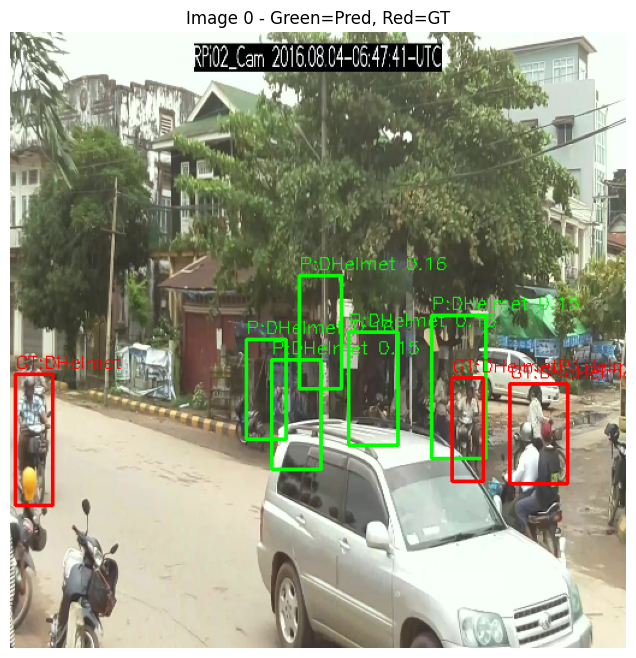

In [ ]:
# Create the id to label mapping
id_to_label = {v: k for k, v in detr_label_map.items()}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DETRModel(num_classes=len(detr_label_map)+1, num_queries=num_queries)

model_path = os.path.join('/content/drive/My Drive/Assignment/DETR', 'detr_best.pth')

# Load weights first
model.load_state_dict(torch.load(model_path, map_location=device))

# Then move model to the device
model = model.to(device)


# Create the validation data loader if it's not already defined
if 'valid_data_loader' not in locals():
    valid_dataset = DETRDataset(
        dataframe=df_val_detr,
        transforms=get_valid_transforms(),
        img_size=(512, 512)
    )
    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4, # Adjust num_workers based on your system
        collate_fn=collate_fn_detr
    )

# Reduce the probability threshold for visualization
visualize_predictions(model, valid_data_loader, device, conf_threshold=0.1, num_images=1, label_map=id_to_label, topk=5) # Pass id_to_label

# Task
Evaluate the trained DETR model for helmet detection using the test dataset "/content/description of DETR process.txt". The evaluation should include calculating Precision, Recall, Accuracy, and F1 score. Additionally, perform scenario-based evaluation if possible and visualize predictions on sample test images.

## Load the test dataset

### Subtask:
Load the test dataset into a pandas DataFrame, similar to how the training and validation data were loaded.


In [ ]:
# Define the path to the test dataset CSV file
df_test_detr_path = '/content/drive/My Drive/dataset/preprocessed_data/detr_dataframes/df_test_detr.csv'

# Use the pd.read_csv() function to load the data
df_test_detr = pd.read_csv(df_test_detr_path)

# Print a confirmation message and display the first few rows
print(f"Test dataset loaded from {df_test_detr_path}")
print("\nFirst few rows of loaded df_test_detr:")
display(df_test_detr.head())

# Print the info of the loaded DataFrame
print("\nInfo of loaded df_test_detr:")
df_test_detr.info()

Test dataset loaded from /content/drive/My Drive/dataset/preprocessed_data/detr_dataframes/df_test_detr.csv

First few rows of loaded df_test_detr:


image_path  class_id     x    y  \
0  /kaggle/input/helmet-dataset-by-osf-lite/helme...         1  1679  601   
1  /kaggle/input/helmet-dataset-by-osf-lite/helme...         1  1550  658   
2  /kaggle/input/helmet-dataset-by-osf-lite/helme...         2   386  572   
3  /kaggle/input/helmet-dataset-by-osf-lite/helme...         0    55  533   
4  /kaggle/input/helmet-dataset-by-osf-lite/helme...         1  1469  618   

     w    h  img_width  img_height video_sequence  
0   95  153       1920        1080   Bago_urban_7  
1  143  262       1920        1080   Bago_urban_7  
2   88  153       1920        1080   Bago_urban_7  
3   58  106       1920        1080   Bago_urban_7  
4  100  200       1920        1080   Bago_urban_7


Info of loaded df_test_detr:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 886 entries, 0 to 885
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_path      886 non-null    object
 1   class_id        886 non-null    int64 
 2   x               886 non-null    int64 
 3   y               886 non-null    int64 
 4   w               886 non-null    int64 
 5   h               886 non-null    int64 
 6   img_width       886 non-null    int64 
 7   img_height      886 non-null    int64 
 8   video_sequence  886 non-null    object
dtypes: int64(7), object(2)
memory usage: 62.4+ KB


## Prepare Test DataLoaders

### Subtask:
Create a PyTorch `DataLoader` for the test dataset using the `DETRDataset` class and the appropriate transforms and collate function.

In [ ]:
# Assuming DETRDataset, get_valid_transforms, collate_fn_detr,
# and current_dataset_path are defined in previous cells (like cell 8ecbbf9d)

import os
import pandas as pd
from torch.utils.data import DataLoader # Import DataLoader

# Ensure df_test_detr is loaded (should be from cell 00ae2aed)
if 'df_test_detr' not in globals():
     print("Error: df_test_detr DataFrame is not loaded. Please run cell 00ae2aed first.")
     # You might want to exit or handle this more gracefully
     raise NameError("df_test_detr not found.")

# Ensure current_dataset_path is defined from the kagglehub download cell (cell 60aae605 or 8ecbbf9d)
# Retrieve the global 'path' variable set by kagglehub.dataset_download
current_dataset_path = globals().get('path', None)

if current_dataset_path is None:
     print("Error: current_dataset_path is not defined. Please run the cell that downloads the dataset and defines this variable (cell 60aae605 or 8ecbbf9d).")
     raise NameError("current_dataset_path not found.")

# --- Define the reconstruct_image_path function here ---
def reconstruct_image_path(image_path_str, current_dataset_path):
    # This function takes an image path string from the loaded dataframe
    # and the actual base path where the dataset was downloaded
    # and reconstructs the correct path to the image file.
    # Example: '/kaggle/input/helmet-dataset-by-osf-lite/helmet-dataset/images/part_1/Bago_urban_25/20.jpg'

    parts = image_path_str.split(os.sep)
    if len(parts) >= 3:
        try:
            # Try to find 'images' and then the part after it
            images_idx = parts.index('images')
            # Assuming the structure is .../images/part_X/video_sequence/image_filename.jpg
            if len(parts) > images_idx + 3:
                part = parts[images_idx + 1]
                video_sequence = parts[images_idx + 2]
                image_filename = parts[-1]
                return os.path.join(current_dataset_path, 'images', part, video_sequence, image_filename)
            else:
                print(f"Warning: Could not reconstruct path for {image_path_str}. Parts after 'images' insufficient: {parts[images_idx+1:]}")
                return None # Cannot reconstruct path
        except ValueError:
             # If 'images' is not in the path, try to find the 'helmet-dataset' part
             try:
                 helmet_dataset_idx = parts.index('helmet-dataset')
                 # Assuming the structure is .../helmet-dataset/images/part_X/video_sequence/image_filename.jpg
                 if len(parts) > helmet_dataset_idx + 4:
                      part = parts[helmet_dataset_idx + 2]
                      video_sequence = parts[helmet_dataset_idx + 3]
                      image_filename = parts[-1]
                      return os.path.join(current_dataset_path, 'images', part, video_sequence, image_filename)
                 else:
                     print(f"Warning: Could not reconstruct path for {image_path_str}. Parts after 'helmet-dataset' insufficient: {parts[helmet_dataset_idx+1:]}")
                     return None # Cannot reconstruct path
             except ValueError:
                print(f"Warning: Could not reconstruct path for {image_path_str}. Neither 'images' nor 'helmet-dataset' found.")
                return None # Cannot reconstruct path
    else:
        print(f"Warning: Could not reconstruct path for {image_path_str}. Path has insufficient parts.")
        return None # Cannot reconstruct path
# --- End of reconstruct_image_path function ---


# --- Apply path reconstruction to the test dataframe ---
# We need to create a copy to avoid modifying the original loaded dataframe if it's used elsewhere
df_test_detr_corrected_paths = df_test_detr.copy()

df_test_detr_corrected_paths['image_path'] = df_test_detr_corrected_paths['image_path'].apply(lambda x: reconstruct_image_path(x, current_dataset_path + '/helmet-dataset')) # Pass the corrected base path

# Drop rows where the path could not be reconstructed (optional, but good practice)
df_test_detr_corrected_paths.dropna(subset=['image_path'], inplace=True)

print("\nImage paths in test dataframe updated.")
print(f"Test data after path correction: {df_test_detr_corrected_paths.shape}")

# --- END NEW CODE ---


# Create DETR Test Dataset using the dataframe with corrected paths
test_dataset_detr = DETRDataset(
    dataframe=df_test_detr_corrected_paths, # Use the corrected paths dataframe
    transforms=get_valid_transforms(), # Using validation transforms for testing
    img_size=(512, 512)
)

# Create DETR Test DataLoader
# Use the same BATCH_SIZE as defined for training/validation
BATCH_SIZE = globals().get('BATCH_SIZE', 8) # Ensure BATCH_SIZE is defined, default to 8 if not
test_data_loader_detr = DataLoader(
    test_dataset_detr,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle test data
    num_workers=2, # Reduced num_workers as suggested in previous warning/output
    collate_fn=collate_fn_detr
)

print("DETR Test DataLoader created.")
print(f"Number of batches in test_data_loader_detr: {len(test_data_loader_detr)}")

# Optional: Inspect a batch from the DataLoader
print("\nInspecting a batch from DETR Test DataLoader:")
try:
    images, targets = next(iter(test_data_loader_detr))
    print("Image batch shape:", images.shape)
    print("Targets (list of dictionaries) length:", len(targets))
    print("Sample target for the first image in the batch:")
    print(targets[0])
except Exception as e:
    print(f"Could not inspect batch: {e}")


Image paths in test dataframe updated.
Test data after path correction: (886, 9)
DETR Test DataLoader created.
Number of batches in test_data_loader_detr: 34

Inspecting a batch from DETR Test DataLoader:
Image batch shape: torch.Size([8, 3, 512, 512])
Targets (list of dictionaries) length: 8
Sample target for the first image in the batch:
{'boxes': tensor([[0.8992, 0.6273, 0.0495, 0.1417]]), 'labels': tensor([1]), 'image_id': tensor([0]), 'area': tensor([1837.5116]), 'orig_size': tensor([1080, 1920]), 'size': tensor([512, 512])}


## Implement Metric Calculation

### Subtask:
Define a function to calculate Precision, Recall, Accuracy, and F1 score for object detection.

In [ ]:
import torch
from torchvision.ops import box_iou
from collections import defaultdict
from tqdm.autonotebook import tqdm # Ensure tqdm is imported

def calculate_detection_metrics(model, data_loader, device, iou_threshold=0.5, conf_threshold=0.05):
    model.eval()
    # Initialize counts for true positives, false positives, and false negatives per class
    true_positives = defaultdict(int)
    false_positives = defaultdict(int)
    # false_negatives = defaultdict(int) # We'll calculate FN based on total GT and matched GT

    # Keep track of total ground truth objects per class
    total_ground_truth = defaultdict(int)
    # Keep track of matched ground truth objects per class across the dataset
    matched_ground_truth_total = defaultdict(int)


    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Calculating Metrics"):
            images = images.to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for i in range(len(images)):
                # --- Process Predictions ---
                probs = outputs['pred_logits'][i].softmax(-1)
                scores, pred_labels = probs[:, :-1].max(-1)  # exclude "no object"

                # Apply confidence threshold
                confident_preds_mask = scores > conf_threshold
                pred_scores = scores[confident_preds_mask]
                pred_labels = pred_labels[confident_preds_mask]
                pred_boxes_cxcywh = outputs['pred_boxes'][i][confident_preds_mask]

                # Convert predicted boxes to pixel xyxy
                # Ensure orig_size is available and has 2 elements
                if 'orig_size' in targets[i] and len(targets[i]['orig_size']) == 2:
                     img_h, img_w = targets[i]['orig_size'].unbind(0) # Use original size for pixel conversion
                else:
                     # Fallback or handle case where orig_size is missing/incorrect
                     # For scenario images with dummy data, this might be the case.
                     # Use the size from the transformed image if orig_size is unreliable.
                     if 'size' in targets[i] and len(targets[i]['size']) == 2:
                         img_h, img_w = targets[i]['size'].unbind(0)
                     else:
                          # Default size if neither is available (shouldn't happen with our dataset class)
                          img_h, img_w = torch.tensor([512, 512], device=device) # Default to transformed size

                pred_boxes_xyxy = box_convert(pred_boxes_cxcywh, in_fmt='cxcywh', out_fmt='xyxy')
                pred_boxes_xyxy = pred_boxes_xyxy * torch.tensor([img_w, img_h, img_w, img_h], device=device)


                # --- Process Ground Truth ---
                gt_labels = targets[i]['labels']
                gt_boxes_cxcywh = targets[i]['boxes']

                # Convert ground truth boxes to pixel xyxy (do this unconditionally)
                if len(gt_boxes_cxcywh) > 0:
                     gt_boxes_xyxy = box_convert(gt_boxes_cxcywh, in_fmt='cxcywh', out_fmt='xyxy')
                     gt_boxes_xyxy = gt_boxes_xyxy * torch.tensor([img_w, img_h, img_w, img_h], device=device)
                else:
                     # If no ground truth boxes, create an empty tensor with the correct shape
                     gt_boxes_xyxy = torch.empty((0, 4), device=device)


                # Update total ground truth counts for this image's GTs
                for label in gt_labels.tolist():
                    total_ground_truth[label] += 1

                # --- Match Predictions to Ground Truth and Calculate TP, FP, FN ---
                matched_gts_indices = set() # Keep track of GT indices that have been matched in THIS image

                # Only attempt matching if there are both predictions and ground truth
                if len(pred_boxes_xyxy) > 0 and len(gt_boxes_xyxy) > 0:
                    # Calculate IoU between all predicted and ground truth boxes
                    iou_matrix = box_iou(pred_boxes_xyxy, gt_boxes_xyxy) # shape (num_preds, num_gts)

                    # Find the best GT match for each prediction (greedy matching)
                    # Iterate through predictions and find the best *unmatched* GT.
                    for pred_idx in range(len(pred_boxes_xyxy)):
                        best_iou = 0
                        best_gt_idx = -1

                        # Find the best GT match for the current prediction
                        for gt_idx in range(len(gt_boxes_xyxy)):
                            if gt_idx not in matched_gts_indices: # Only consider unmatched GTs in this image
                                current_iou = iou_matrix[pred_idx, gt_idx]
                                if current_iou > best_iou:
                                    best_iou = current_iou
                                    best_gt_idx = gt_idx

                        # Check if the best match meets the IoU threshold and class matches
                        if best_iou >= iou_threshold and best_gt_idx != -1:
                            if pred_labels[pred_idx] == gt_labels[best_gt_idx]:
                                # This is a True Positive
                                true_positives[pred_labels[pred_idx].item()] += 1
                                matched_gts_indices.add(best_gt_idx) # Mark this GT as matched in THIS image
                                # Increment matched GT total count for this class
                                matched_ground_truth_total[gt_labels[best_gt_idx].item()] += 1

                            else:
                                # This is a False Positive (correct localization, wrong class)
                                false_positives[pred_labels[pred_idx].item()] += 1
                        else:
                            # This is a False Positive (no match or IoU below threshold)
                             false_positives[pred_labels[pred_idx].item()] += 1

                elif len(pred_boxes_xyxy) > 0 and len(gt_boxes_xyxy) == 0:
                    # Predictions were made, but no ground truth objects exist in this image
                    # All predictions are False Positives
                    for label in pred_labels.tolist():
                         false_positives[label] += 1
                # If len(pred_boxes_xyxy) == 0 and len(gt_boxes_xyxy) > 0, these will contribute to false negatives
                # If len(pred_boxes_xyxy) == 0 and len(gt_boxes_xyxy) == 0, nothing to update for this image

    # --- Aggregate and Calculate Final Metrics ---
    # Calculate False Negatives per class based on total GT and matched GT totals
    false_negatives = defaultdict(int)
    all_classes = sorted(list(set(total_ground_truth.keys()).union(matched_ground_truth_total.keys())))
    for class_id in all_classes:
        total_gt_class = total_ground_truth.get(class_id, 0)
        matched_gt_class = matched_ground_truth_total.get(class_id, 0)
        false_negatives[class_id] = total_gt_class - matched_gt_class


    # Calculate overall metrics
    overall_tp = sum(true_positives.values())
    overall_fp = sum(false_positives.values())
    overall_fn = sum(false_negatives.values()) # Sum of per-class FNs
    overall_total_gt = sum(total_ground_truth.values())

    # Precision, Recall, F1 (handle division by zero)
    overall_precision = overall_tp / (overall_tp + overall_fp) if (overall_tp + overall_fp) > 0 else 0.0
    overall_recall = overall_tp / overall_total_gt if overall_total_gt > 0 else 0.0
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0.0

    metrics = {
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1': overall_f1,
        'per_class': {}
    }

    # Calculate per-class metrics
    all_classes = sorted(list(set(true_positives.keys()).union(false_positives.keys()).union(false_negatives.keys()).union(total_ground_truth.keys())))

    for class_id in all_classes:
        tp = true_positives.get(class_id, 0)
        fp = false_positives.get(class_id, 0)
        fn = false_negatives.get(class_id, 0)
        total_gt_class = total_ground_truth.get(class_id, 0)


        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / total_gt_class if total_gt_class > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        metrics['per_class'][class_id] = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'tp': tp, # Add raw counts for debugging/understanding
            'fp': fp,
            'fn': fn,
            'total_gt': total_gt_class
        }

    return metrics

## Calculate and Report Metrics

### Subtask:
Use the defined `calculate_detection_metrics` function to compute Precision, Recall, and F1 score on the test dataset and report the results.

In [ ]:
# Assuming calculate_detection_metrics function, DETRModel class,
# test_data_loader_detr, device, and detr_label_map are defined

import torch
from torchvision.ops import box_convert # Import box_convert here

# Create the model instance
num_classes_model = len(detr_label_map) + 1  # include "no object"
model = DETRModel(num_classes=num_classes_model, num_queries=num_queries)

# Load the trained model weights
model_path = os.path.join('/content/drive/My Drive/Assignment/DETR', 'detr_best.pth')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(model_path, map_location=device))

# Move the model to the device
model.to(device)

# Set the confidence threshold for evaluation (you can adjust this)
evaluation_conf_threshold = 0.1 # Lowering for potentially more detections

# Calculate the detection metrics
test_metrics = calculate_detection_metrics(
    model=model,
    data_loader=test_data_loader_detr,
    device=device,
    conf_threshold=evaluation_conf_threshold
)

# Print the overall metrics
print("\n--- Overall Test Set Metrics ---")
print(f"Precision: {test_metrics['overall_precision']:.4f}")
print(f"Recall: {test_metrics['overall_recall']:.4f}")
print(f"F1 Score: {test_metrics['overall_f1']:.4f}")

# Print per-class metrics (optional)
print("\n--- Per-Class Test Set Metrics ---")
id_to_label = {v: k for k, v in detr_label_map.items()}
for class_id, metrics in test_metrics['per_class'].items():
     class_name = id_to_label.get(class_id, f"Class {class_id}")
     print(f"Class '{class_name}' (ID {class_id}):")
     print(f"  Precision: {metrics['precision']:.4f}")
     print(f"  Recall: {metrics['recall']:.4f}")
     print(f"  F1 Score: {metrics['f1']:.4f}")

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_main
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Calculating Metrics:   0%|          | 0/34 [00:00<?, ?it/s]


--- Overall Test Set Metrics ---
Precision: 0.0049
Recall: 0.1354
F1 Score: 0.0094

--- Per-Class Test Set Metrics ---
Class 'DHelmet' (ID 0):
  Precision: 0.0049
  Recall: 0.2286
  F1 Score: 0.0096
Class 'DNoHelmet' (ID 1):
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 'DHelmetP1Helmet' (ID 2):
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000
Class 'DNoHelmetP1NoHelmet' (ID 3):
  Precision: 0.0000
  Recall: 0.0000
  F1 Score: 0.0000


# Task
Analyze the performance of an object detection model on images representing bright, dark, and rainy scenarios. Calculate and report the Accuracy, Precision, Recall, and F1-Score for each scenario using the provided augmented images: "too_dark_augmented.jpg", "too_bright_augmented.jpg", and "rainy_augmented.jpg" from the directory "/content/drive/My Drive/dataset/augmented_samples". Additionally, identify and describe the key challenges and observations specific to object detection in each of these scenarios, referencing the image "Bago_urban_52/20.jpg" if relevant to the observations.

## Calculate scenario metrics

### Subtask:
Use the `calculate_detection_metrics` function to compute Precision, Recall, and F1 score for each scenario DataLoader.


In [ ]:
import pandas as pd
import os
import shutil
import numpy as np
from PIL import Image

# Define the path to the NEW annotation file
annotation_path = '/content/drive/My Drive/dataset/data/yolo_train/test/Mandalay_1_128/60.txt'

# Define the directory containing the augmented images
augmented_image_dir = '/content/drive/My Drive/dataset/augmented_samples'

# Define the filenames of the four augmented images
augmented_image_filenames = [
    'original_image.jpg',
    'rainy_weather.jpg',
    'dark_weather.jpg',
    'bright_weather.jpg'
]

# --- Load and parse the annotation file ---
# Lists to store parsed annotations (normalized cxcywh)
gt_boxes_cxcywh_norm = []
gt_labels = []

try:
    with open(annotation_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                # Normalized cx, cy, w, h are already in the file
                cx_norm, cy_norm, w_norm, h_norm = map(float, parts[1:])

                gt_boxes_cxcywh_norm.append([cx_norm, cy_norm, w_norm, h_norm])
                gt_labels.append(class_id)
            else:
                print(f"Warning: Skipping malformed line in {annotation_path}: {line.strip()}")

except FileNotFoundError:
    print(f"Error: Annotation file not found at {annotation_path}")
    raise FileNotFoundError(f"Annotation file not found: {annotation_path}")
except Exception as e:
    print(f"An error occurred while reading or parsing the annotation file: {e}")
    raise RuntimeError(f"Error parsing annotation file: {e}")

# Convert lists to numpy arrays
gt_boxes_cxcywh_norm_np = np.array(gt_boxes_cxcywh_norm, dtype=np.float32) if gt_boxes_cxcywh_norm else np.zeros((0, 4), dtype=np.float32)
gt_labels_np = np.array(gt_labels, dtype=np.int64) if gt_labels else np.zeros((0,), dtype=np.int64)

print(f"Loaded {len(gt_labels_np)} ground truth annotations from {annotation_path}")


# --- Copy the augmented images to a local Colab directory ---
local_scenario_eval_dir = '/content/individual_scenario_eval'
os.makedirs(local_scenario_eval_dir, exist_ok=True)

local_augmented_image_paths = {} # Use a dictionary to store paths by scenario name
print(f"\nCopying augmented images to local directory: {local_scenario_eval_dir}")
for filename in augmented_image_filenames:
    google_drive_path = os.path.join(augmented_image_dir, filename)
    local_path = os.path.join(local_scenario_eval_dir, filename)
    scenario_name = filename.replace('.jpg', '').replace('_augmented', '').replace('_weather', '').replace('too_', '') # Extract scenario name

    if os.path.exists(google_drive_path):
        try:
            shutil.copy(google_drive_path, local_path)
            local_augmented_image_paths[scenario_name] = local_path # Store local path
            print(f"Copied: {filename}")
        except Exception as e:
            print(f"Error copying {filename}: {e}")
    else:
        print(f"Source image not found: {google_drive_path}")

if not local_augmented_image_paths:
    print("No augmented images were successfully copied. Cannot proceed with scenario evaluation.")
else:
    print(f"Successfully copied {len(local_augmented_image_paths)} augmented images.")

    # --- Prepare Individual Scenario DataFrames ---
    # Assume original image dimensions (based on previous data inspection or load from one of the images)
    # Let's load dimensions from one of the copied images
    img_width, img_height = 1920, 1080 # Default dummy size
    if local_augmented_image_paths:
        try:
            # Get the path of the first copied image (e.g., original)
            first_image_key = 'original_image' if 'original_image' in local_augmented_image_paths else list(local_augmented_image_paths.keys())[0]
            first_image_path = local_augmented_image_paths[first_image_key]
            with Image.open(first_image_path) as img:
                img_width, img_height = img.size
            print(f"\nUsing image dimensions {img_width}x{img_height} from {os.path.basename(first_image_path)}")
        except Exception as e:
            print(f"Warning: Could not get image size from first copied image. Using dummy size ({img_width}, {img_height}). Error: {e}")


    # Dictionary to store individual scenario DataFrames
    scenario_dataframes = {}

    for scenario_name, image_path in local_augmented_image_paths.items():
        scenario_data = []
        # Each image gets the SAME set of ground truth annotations
        if len(gt_labels_np) > 0:
            for i in range(len(gt_labels_np)):
                # Convert normalized cxcywh to absolute xywh for the DataFrame (as expected by DETRDataset)
                cx_norm, cy_norm, w_norm, h_norm = gt_boxes_cxcywh_norm_np[i]
                x_norm = cx_norm - w_norm / 2
                y_norm = cy_norm - h_norm / 2
                w_abs = w_norm * img_width
                h_abs = h_norm * img_height
                x_abs = x_norm * img_width
                y_abs = y_norm * img_height

                scenario_data.append({
                    'image_path': image_path,
                    'class_id': gt_labels_np[i],
                    'x': x_abs,
                    'y': y_abs,
                    'w': w_abs,
                    'h': h_abs,
                    'img_width': img_width, # Use actual or dummy width
                    'img_height': img_height, # Use actual or dummy height
                    'video_sequence': scenario_name # Use scenario name as video sequence
                })
        else:
            # Handle case with no ground truth annotations at all
            scenario_data.append({
                'image_path': image_path,
                'class_id': [], # Empty list
                'x': [],
                'y': [],
                'w': [],
                'h': [],
                'img_width': img_width,
                'img_height': img_height,
                'video_sequence': scenario_name
            })
            print(f"Warning: No ground truth annotations found in {annotation_path}. DataFrame created with empty annotations for {os.path.basename(image_path)}.")


        # Create the DataFrame for the current scenario
        scenario_dataframes[scenario_name] = pd.DataFrame(scenario_data)

    print("\nIndividual DataFrames created for each scenario.")
    # Optional: Display head of each dataframe
    # for name, df in scenario_dataframes.items():
    #     print(f"\n{name} Scenario DataFrame:")
    #     display(df.head())

Loaded 14 ground truth annotations from /content/drive/My Drive/dataset/data/yolo_train/test/Mandalay_1_128/60.txt

Copying augmented images to local directory: /content/individual_scenario_eval
Copied: original_image.jpg
Copied: rainy_weather.jpg
Copied: dark_weather.jpg
Copied: bright_weather.jpg
Successfully copied 4 augmented images.

Using image dimensions 1920x1080 from original_image.jpg

Individual DataFrames created for each scenario.


In [ ]:
# Assuming DETRDataset, get_valid_transforms, and collate_fn_detr are defined
# Assuming scenario_dataframes dictionary is defined (from previous step)

# Dictionary to store individual scenario DataLoaders
scenario_data_loaders = {}

print("Preparing DataLoaders for individual scenarios...")

for scenario_name, dataframe in scenario_dataframes.items():
    if not dataframe.empty:
        # Create DETR Dataset for the current scenario
        scenario_dataset = DETRDataset(
            dataframe=dataframe,
            transforms=get_valid_transforms(), # Use validation transforms
            img_size=(512, 512)
        )

        # Create DataLoader for the current scenario dataset
        # Use batch size 1 for evaluating a single image
        scenario_data_loader = DataLoader(
            scenario_dataset,
            batch_size=1,
            shuffle=False, # No need to shuffle a single image
            num_workers=1, # Suitable number of workers for a single image
            collate_fn=collate_fn_detr # Use the same collate function
        )
        scenario_data_loaders[scenario_name] = scenario_data_loader
        print(f"DataLoader created for '{scenario_name}' scenario. Batches: {len(scenario_data_loader)}")
    else:
        print(f"Skipping DataLoader creation for '{scenario_name}' scenario as its DataFrame is empty.")


print("\nIndividual Scenario DataLoaders created.")

# Optional: Inspect a batch from each DataLoader
# print("\nInspecting a batch from each DataLoader:")
# for scenario_name, loader in scenario_data_loaders.items():
#     print(f"\nScenario: {scenario_name}")
#     try:
#         images, targets = next(iter(loader))
#         print("Image batch shape:", images.shape)
#         print("Targets (list of dictionaries) length:", len(targets))
#         if len(targets) > 0:
#             print("Sample target for the first image in the batch:")
#             print(targets[0])
#     except Exception as e:
#         print(f"Could not inspect batch for {scenario_name}: {e}")

Preparing DataLoaders for individual scenarios...
DataLoader created for 'original_image' scenario. Batches: 1
DataLoader created for 'rainy' scenario. Batches: 1
DataLoader created for 'dark' scenario. Batches: 1
DataLoader created for 'bright' scenario. Batches: 1

Individual Scenario DataLoaders created.


In [ ]:
# Assuming calculate_detection_metrics function, DETRModel class,
# scenario_data_loaders, device, detr_label_map, and num_queries are defined

# Ensure the model is loaded and on the correct device (re-loading if necessary)
if 'model' not in globals() or 'device' not in globals() or not isinstance(model, DETRModel):
    print("\nLoading model for individual scenario evaluation...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_classes_model = len(detr_label_map) + 1  # include "no object"
    model = DETRModel(num_classes=num_classes_model, num_queries=num_queries)
    model_path = os.path.join('/content/drive/My Drive/Assignment/DETR', 'detr_best.pth')
    if os.path.exists(model_path):
         model.load_state_dict(torch.load(model_path, map_location=device))
         model.to(device)
         model.eval() # Set model to evaluation mode
         print("Model loaded successfully.")
    else:
         print(f"Error: Model file not found at {model_path}. Cannot perform individual scenario evaluation.")
         model = None # Set model to None if loading fails

scenario_metrics = {} # Dictionary to store metrics for each scenario

if model is not None:
    # Set the confidence threshold for evaluation (can be adjusted)
    scenario_conf_threshold = 0.1 # Using the same threshold as test set evaluation

    print("\nCalculating metrics for individual scenarios:")
    for scenario_name, data_loader in scenario_data_loaders.items():
        print(f"\nCalculating metrics for {scenario_name} scenario...")
        metrics = calculate_detection_metrics(
            model=model,
            data_loader=data_loader,
            device=device,
            conf_threshold=scenario_conf_threshold
        )
        scenario_metrics[scenario_name] = metrics
        print(f"Metrics calculated for {scenario_name}.")

    print("\nIndividual Scenario metrics calculation complete.")

else:
    print("\nModel not loaded. Skipping individual scenario metric calculation.")


Calculating metrics for individual scenarios:

Calculating metrics for original_image scenario...


Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Metrics calculated for original_image.

Calculating metrics for rainy scenario...


Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Metrics calculated for rainy.

Calculating metrics for dark scenario...


Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Metrics calculated for dark.

Calculating metrics for bright scenario...


Calculating Metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Metrics calculated for bright.

Individual Scenario metrics calculation complete.


In [ ]:
# Assuming scenario_metrics dictionary and detr_label_map are defined

print("\n--- Individual Scenario Evaluation Metrics ---")

# Create the id to label mapping for printing
id_to_label = {v: k for k, v in detr_label_map.items()}

for scenario_name, metrics in scenario_metrics.items():
    print(f"\n--- {scenario_name.capitalize()} Scenario Metrics ---")
    print(f"Overall Precision: {metrics['overall_precision']:.4f}")
    print(f"Overall Recall: {metrics['overall_recall']:.4f}")
    print(f"Overall F1 Score: {metrics['overall_f1']:.4f}")

    print(f"--- {scenario_name.capitalize()} Per-Class Metrics ---")
    # Sort class IDs for consistent printing
    sorted_class_ids = sorted(metrics['per_class'].keys())
    for class_id in sorted_class_ids:
         class_metrics = metrics['per_class'][class_id]
         class_name = id_to_label.get(class_id, f"Class {class_id}")
         print(f"  Class '{class_name}' (ID {class_id}):")
         print(f"    Precision: {class_metrics['precision']:.4f}")
         print(f"    Recall: {class_metrics['recall']:.4f}")
         print(f"    F1 Score: {class_metrics['f1']:.4f}")
         print(f"    True Positives: {class_metrics['tp']}")
         print(f"    False Positives: {class_metrics['fp']}")
         print(f"    False Negatives: {class_metrics['fn']}")
         print(f"    Total Ground Truth: {class_metrics['total_gt']}")


--- Individual Scenario Evaluation Metrics ---

--- Original_image Scenario Metrics ---
Overall Precision: 0.0440
Overall Recall: 0.2857
Overall F1 Score: 0.0762
--- Original_image Per-Class Metrics ---
  Class 'DHelmet' (ID 0):
    Precision: 0.0440
    Recall: 0.4000
    F1 Score: 0.0792
    True Positives: 4
    False Positives: 87
    False Negatives: 6
    Total Ground Truth: 10
  Class 'DNoHelmet' (ID 1):
    Precision: 0.0000
    Recall: 0.0000
    F1 Score: 0.0000
    True Positives: 0
    False Positives: 0
    False Negatives: 4
    Total Ground Truth: 4

--- Rainy Scenario Metrics ---
Overall Precision: 0.0440
Overall Recall: 0.2857
Overall F1 Score: 0.0762
--- Rainy Per-Class Metrics ---
  Class 'DHelmet' (ID 0):
    Precision: 0.0440
    Recall: 0.4000
    F1 Score: 0.0792
    True Positives: 4
    False Positives: 87
    False Negatives: 6
    Total Ground Truth: 10
  Class 'DNoHelmet' (ID 1):
    Precision: 0.0000
    Recall: 0.0000
    F1 Score: 0.0000
    True Positiv


--- Visualizing Predictions for Individual Scenarios ---

Visualizing predictions for the Original_image Scenario:
Image 0:
Max score: 0.1575334221124649
Mean score: 0.12992380559444427
Scores > 0.05: 91
Scores > 0.3: 0


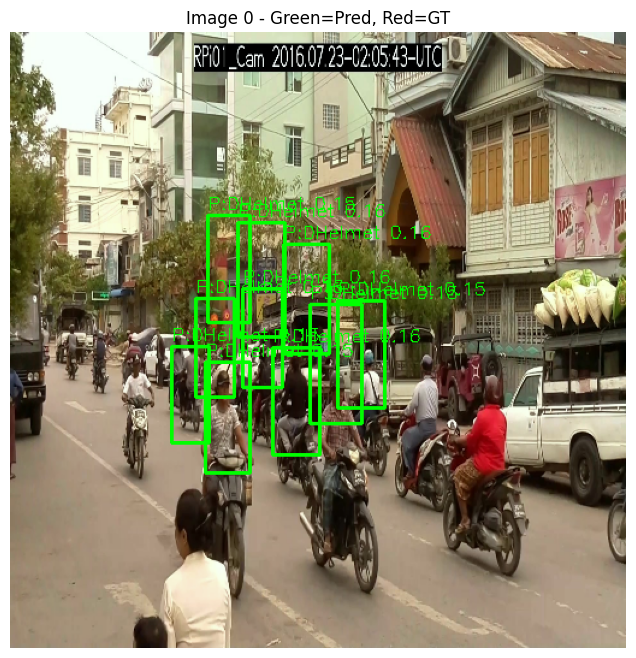


Visualizing predictions for the Rainy Scenario:
Image 0:
Max score: 0.15883144736289978
Mean score: 0.1304721087217331
Scores > 0.05: 91
Scores > 0.3: 0


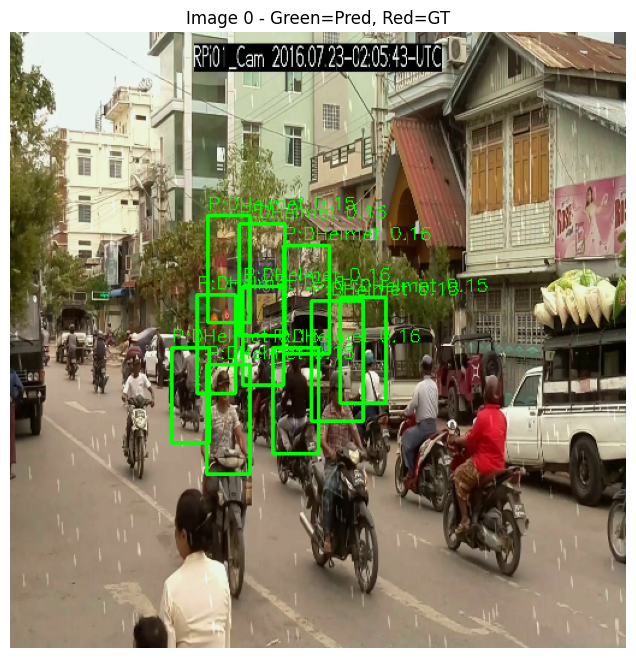


Visualizing predictions for the Dark Scenario:
Image 0:
Max score: 0.1600271612405777
Mean score: 0.13299673795700073
Scores > 0.05: 91
Scores > 0.3: 0


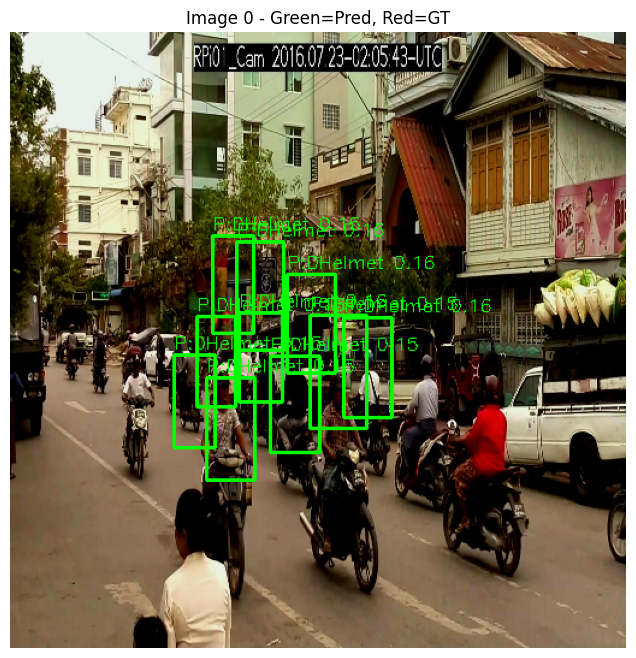


Visualizing predictions for the Bright Scenario:
Image 0:
Max score: 0.15025374293327332
Mean score: 0.1236877515912056
Scores > 0.05: 87
Scores > 0.3: 0


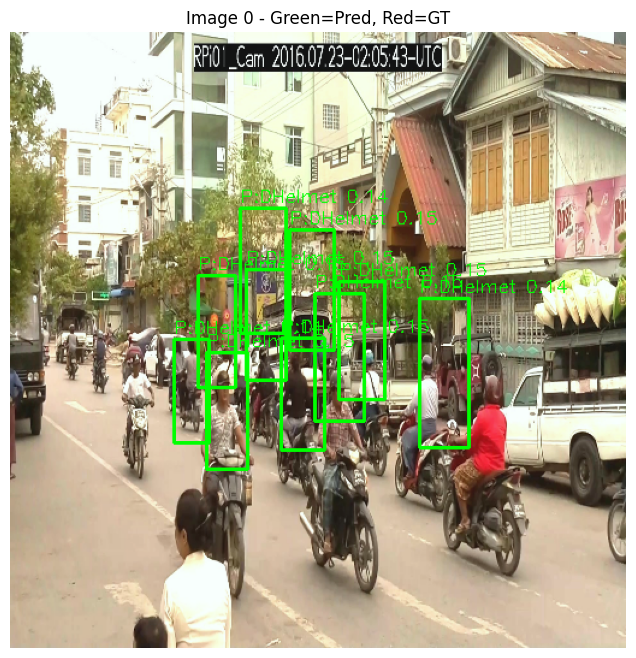

In [ ]:
# Assuming visualize_predictions function, model, device,
# scenario_data_loaders dictionary, and id_to_label are defined

print("\n--- Visualizing Predictions for Individual Scenarios ---")

# Iterate through the scenario data loaders and visualize predictions for each
for scenario_name, data_loader in scenario_data_loaders.items():
    print(f"\nVisualizing predictions for the {scenario_name.capitalize()} Scenario:")

    # Call the visualize_predictions function for the current scenario's data loader
    # Set draw_gt=False to not draw ground truth boxes
    visualize_predictions(
        model=model,
        data_loader=data_loader,
        device=device,
        conf_threshold=0.1, # Use the same threshold as for evaluation
        num_images=1, # Visualize only one image per scenario
        label_map=id_to_label, # Pass the label map for displaying class names
        topk=10, # Display top 10 predictions
        draw_gt=False # Do not draw ground truth boxes
    )

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.ops import box_iou
import numpy as np
from tqdm.autonotebook import tqdm
from IPython.display import display # Import display
from collections import defaultdict # Import defaultdict

def plot_f1_confidence_curve(model, data_loader, device, iou_threshold=0.5, label_map=None):
    model.eval()
    all_pred_info = [] # List of dicts: {'score': float, 'label': int, 'bbox': np.array, 'image_idx': int}
    all_gt_info = [] # List of lists of dicts: [[{'label': int, 'bbox': np.array, 'matched': bool}], ...]

    # Get all unique class IDs present in the ground truth
    all_gt_class_ids = set()


    print("\nCollecting detailed prediction and ground truth data for F1-Confidence curve...")
    with torch.no_grad():
        for images, targets in tqdm(data_loader, desc="Collecting Detailed Data"):
            images = images.to(device)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for i in range(len(images)):
                 # Ensure orig_size is available and has 2 elements
                if 'orig_size' in targets[i] and len(targets[i]['orig_size']) == 2:
                     img_h, img_w = targets[i]['orig_size'].unbind(0)
                elif 'size' in targets[i] and len(targets[i]['size']) == 2:
                     img_h, img_w = targets[i]['size'].unbind(0)
                else:
                      img_h, img_w = torch.tensor([512, 512], device=device) # Default

                # Predictions
                probs = outputs['pred_logits'][i].softmax(-1)
                scores, pred_labels = probs[:, :-1].max(-1)  # exclude "no object"
                pred_boxes_cxcywh = outputs['pred_boxes'][i]
                pred_boxes_xyxy = box_convert(pred_boxes_cxcywh, in_fmt='cxcywh', out_fmt='xyxy')
                pred_boxes_xyxy = pred_boxes_xyxy * torch.tensor([img_w, img_h, img_w, img_h], device=device)

                for j in range(len(scores)):
                    all_pred_info.append({
                        'score': scores[j].item(),
                        'label': pred_labels[j].item(),
                        'bbox': pred_boxes_xyxy[j].cpu().numpy(), # Store as numpy array
                        'image_idx': len(all_gt_info) # Store which GT list it corresponds to
                    })


                # Ground Truth
                gt_labels = targets[i]['labels']
                gt_boxes_cxcywh = targets[i]['boxes']
                if len(gt_boxes_cxcywh) > 0:
                     gt_boxes_xyxy = box_convert(gt_boxes_cxcywh, in_fmt='cxcywh', out_fmt='xyxy')
                     gt_boxes_xyxy = gt_boxes_xyxy * torch.tensor([img_w, img_h, img_w, img_h], device=device)
                else:
                     gt_boxes_xyxy = torch.empty((0, 4), device=device)


                current_image_gts = []
                for k in range(len(gt_labels)):
                    current_image_gts.append({
                        'label': gt_labels[k].item(),
                        'bbox': gt_boxes_xyxy[k].cpu().numpy(), # Store as numpy array
                        'matched': False # Track if this GT has been matched
                    })
                    all_gt_class_ids.add(gt_labels[k].item()) # Add GT class ID to set
                all_gt_info.append(current_image_gts) # Append list of GTs for this image


    # Sort predictions by confidence score in descending order
    all_pred_info.sort(key=lambda x: x['score'], reverse=True)

    # Get all unique class IDs present in both GT and predictions
    all_class_ids = sorted(list(all_gt_class_ids.union(set(p['label'] for p in all_pred_info))))


    # Define a range of confidence thresholds to evaluate
    thresholds = np.linspace(0.01, 0.99, 99) # Evaluate at 99 points between 0.01 and 0.99

    # Dictionaries to store per-class metrics for each threshold
    per_class_f1_scores = {class_id: [] for class_id in all_class_ids}
    # per_class_precisions = {class_id: [] for class_id in all_class_ids}
    # per_class_recalls = {class_id: [] for class_id in all_class_ids}

    # Lists to store overall metrics for each threshold
    overall_f1_scores = []
    overall_precisions = []
    overall_recalls = []


    print(f"\nCalculating Per-Class and Overall Precision, Recall, and F1 for {len(thresholds)} confidence thresholds...")
    for conf_threshold in tqdm(thresholds, desc="Evaluating Thresholds"):
        # Reset matched status for all GTs for this threshold
        for img_gts in all_gt_info:
            for gt in img_gts:
                gt['matched'] = False

        # Initialize counts for this threshold (overall and per-class)
        overall_tp, overall_fp = 0, 0
        tp_per_class = defaultdict(int)
        fp_per_class = defaultdict(int)


        # Iterate through predictions (already sorted by confidence) up to the current threshold
        for pred in all_pred_info:
            if pred['score'] >= conf_threshold:
                pred_bbox = pred['bbox']
                pred_label = pred['label']
                image_gt_list = all_gt_info[pred['image_idx']] # Get GTs for this prediction's image

                best_iou = 0
                best_gt_idx = -1

                # Find best matching UNMATCHED GT for this prediction in its image
                # Only consider GTs of the same class for matching
                for gt_idx, gt in enumerate(image_gt_list):
                    if gt['label'] == pred_label and not gt['matched']: # Match only with same class and unmatched GT
                        # Calculate IoU between prediction and current GT
                        pred_bbox_tensor = torch.from_numpy(pred_bbox).unsqueeze(0) # shape (1, 4)
                        gt_bbox_tensor = torch.from_numpy(gt['bbox']).unsqueeze(0) # shape (1, 4)
                        current_iou = box_iou(pred_bbox_tensor, gt_bbox_tensor)[0, 0].item() # Get scalar IoU

                        if current_iou > best_iou:
                            best_iou = current_iou
                            best_gt_idx = gt_idx


                # Check for TP match
                if best_iou >= iou_threshold and best_gt_idx != -1:
                    # This is a True Positive for the predicted class and overall
                    overall_tp += 1
                    tp_per_class[pred_label] += 1
                    image_gt_list[best_gt_idx]['matched'] = True # Mark GT as matched
                else:
                    # This is a False Positive for the predicted class and overall
                    overall_fp += 1
                    fp_per_class[pred_label] += 1

        # Count False Negatives per class and overall for this threshold
        # FN are GTs that were not matched by any prediction above the confidence threshold
        fn_per_class = defaultdict(int)
        total_gt_per_class = defaultdict(int)
        overall_total_gts = 0
        overall_matched_gts = 0

        # Calculate total GT per class/overall and count unmatched GTs (FN)
        for img_gts in all_gt_info:
            for gt in img_gts:
                total_gt_per_class[gt['label']] += 1
                overall_total_gts += 1
                if not gt['matched']:
                     fn_per_class[gt['label']] += 1
                else:
                    overall_matched_gts += 1

        overall_fn = overall_total_gts - overall_matched_gts

        # Calculate per-class F1 scores for this threshold
        for class_id in all_class_ids:
            tp = tp_per_class.get(class_id, 0)
            fp = fp_per_class.get(class_id, 0)
            fn = fn_per_class.get(class_id, 0)
            total_gt = total_gt_per_class.get(class_id, 0)

            # Calculate Precision, Recall, F1 (handle division by zero)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            recall = tp / total_gt if total_gt > 0 else 0.0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

            per_class_f1_scores[class_id].append(f1)
            # per_class_precisions[class_id].append(precision)
            # per_class_recalls[class_id].append(recall)

        # Calculate overall Precision, Recall, F1 for this threshold
        overall_precision = overall_tp / (overall_tp + overall_fp) if (overall_tp + overall_fp) > 0 else 0.0
        overall_recall = overall_tp / overall_total_gts if overall_total_gts > 0 else 0.0
        overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0.0

        overall_precisions.append(overall_precision)
        overall_recalls.append(overall_recall)
        overall_f1_scores.append(overall_f1)


    # Plot the Per-Class and Overall F1-Confidence curves
    plt.figure(figsize=(12, 8))

    # Create a mapping from class ID to class name for the legend
    id_to_label_map = label_map if label_map is not None else {i: f'Class {i}' for i in all_class_ids}

    # Plot Per-Class Curves
    for class_id in all_class_ids:
        class_name = id_to_label_map.get(class_id, f'Class {class_id}')
        plt.plot(thresholds, per_class_f1_scores[class_id], marker='o', linestyle='-', label=f'F1 - {class_name}')

    # Plot Overall Curve
    plt.plot(thresholds, overall_f1_scores, marker='x', linestyle='--', color='black', label='F1 - Overall')


    plt.xlabel('Confidence Threshold')
    plt.ylabel('F1 Score')
    plt.title('Per-Class and Overall F1-Confidence Curves')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1.05) # Set Y-axis limit from 0 to 1 for F1 score
    plt.show()
    print("Per-Class and Overall F1-Confidence curve plot generated.") # Confirmation message
    display(plt.gcf()) # Explicitly display the current figure
    plt.close() # Close the figure to free up memory


    # Optional: Find the threshold that maximizes F1 score per class AND overall
    print("\nBest F1 Score and Threshold:")
    # Overall
    max_overall_f1_index = np.argmax(overall_f1_scores)
    best_overall_f1 = overall_f1_scores[max_overall_f1_index]
    best_overall_threshold = thresholds[max_overall_f1_index]
    print(f"  Overall: Best F1 Score: {best_overall_f1:.4f} at Threshold: {best_overall_threshold:.4f}")

    # Per-Class
    for class_id in all_class_ids:
        class_name = id_to_label_map.get(class_id, f'Class {class_id}')
        f1_scores_np = np.array(per_class_f1_scores[class_id])
        if len(f1_scores_np) > 0 and np.max(f1_scores_np) > 0: # Check if there are valid F1 scores
            max_f1_index = np.argmax(f1_scores_np)
            best_f1 = f1_scores_np[max_f1_index]
            best_threshold = thresholds[max_f1_index]
            print(f"  Class '{class_name}' (ID {class_id}): Best F1 Score: {best_f1:.4f} at Threshold: {best_threshold:.4f}")
        else:
            print(f"  Class '{class_name}' (ID {class_id}): No valid F1 scores could be calculated (e.g., no GT or predictions).")


    # Optional: Plot Precision-Recall curve (Overall and Per-Class) - Requires more data collection
    # This current function structure doesn't easily support PR curves without further modification


Calculating Per-Class and Overall Precision, Recall, and F1 for 99 confidence thresholds...


Evaluating Thresholds:   0%|          | 0/99 [00:00<?, ?it/s]

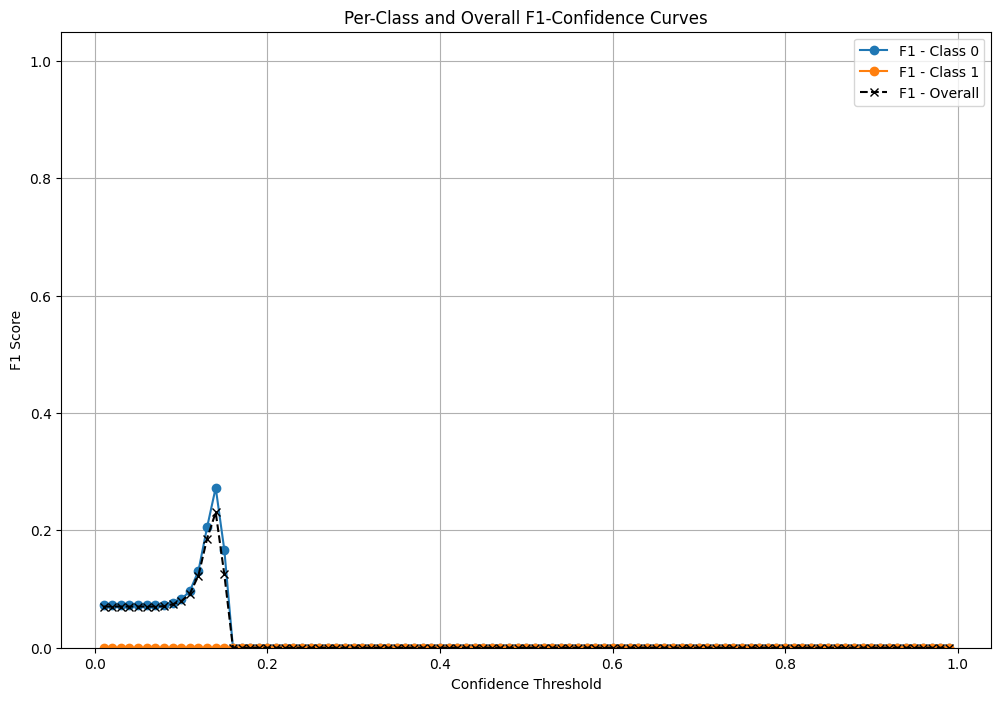

Per-Class and Overall F1-Confidence curve plot generated.


<Figure size 640x480 with 0 Axes>


Best F1 Score and Threshold:
  Overall: Best F1 Score: 0.2308 at Threshold: 0.1400
  Class 'Class 0' (ID 0): Best F1 Score: 0.2727 at Threshold: 0.1400
  Class 'Class 1' (ID 1): No valid F1 scores could be calculated (e.g., no GT or predictions).


In [ ]:
plot_f1_confidence_curve(model, data_loader, device, iou_threshold=0.5)